In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import linalg

In [2]:
class Unicycle:
    def __init__(self, x=None,max_linear_velocity=2, max_angular_velocity=np.pi/3):
        if x is None:
            x = np.zeros(3)
        self.x = x
        self.max_linear_velocity = max_linear_velocity
        self.max_angular_velocity = max_angular_velocity 
    
    def f(self, u, x=None, dt=0.1, save_x=True):
        if x is None:
            x = self.x
            
        # clip controls
        u[0] = np.clip(u[0],-self.max_linear_velocity,self.max_linear_velocity)
        u[1] = np.clip(u[1],-self.max_angular_velocity,self.max_angular_velocity)
        
        
        x_prime = x.copy()
        x_prime[0] = x[0] + u[0]*np.cos(x[2])*dt
        x_prime[1] = x[1] + u[0]*np.sin(x[2])*dt
        x_prime[2] = x[2] + u[1]*dt
        
        if save_x:
            self.x = x_prime
        return x_prime
    
    def getA(self, u, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        A = np.eye(3) 
        A[:,2] += np.array([-u[0]*np.sin(x[2])*dt,
                            u[0]*np.cos(x[2])*dt,
                            0])
        return A
        
    def getB(self, x=None, dt=0.1):
        if x is None:
            x = self.x
            
        B = np.zeros((3,2))
        B[0,0] = np.cos(x[2])*dt
        B[1,0] = np.sin(x[2])*dt
        B[2,1] = dt
        return B
        
    def plot(self, x=None, ax=None):
        if x is None:
            x = self.x
            
        if ax is None:
            ax = plt
            
        get_T = lambda x, y, theta: np.array([[np.cos(theta),-np.sin(theta), x], [np.sin(theta),np.cos(theta), y], [0,0,0]])

        def get_point(T, x,y):
            x,y,_ = T@(np.array([[x,y,1]]).T).reshape(-1)
            return x,y

        x,y,theta = x
        T = get_T(x,y,theta)    
        points = [(0.1,0),(0,-0.05),(0,0.05),(0.1,0)]
        points = [get_point(T,*p) for p in points]
        ax.plot([p[0] for p in points], [p[1] for p in points], color='red')


![](imgs/ilqr.png)

In [3]:
def lqr(A, B, T=100):
    V = np.zeros((3,3))
    C = np.eye(5)
    F = np.hstack([A,B])
    for t in range(T):
        Q = C + F.T@V@F
        Q_xx = Q[:3,:3]
        Q_uu = Q[3:,3:]
        Q_ux = Q[3:,:3]
        Q_xu = Q[:3,3:]
        K = (-linalg.inv(Q_uu))@Q_ux
        V = Q_xx + Q_xu@K + K.T@Q_ux + K.T@Q_uu@K
    return K

In [4]:
dt = 0.1
     
x = np.array([0.,0.,0.]) 

xf = np.array([2.000,2.000,np.pi/2])  

track = []
unicycle = Unicycle(x=x)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
    
    
    
    K = lqr(A, B) 
    u = K@error
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [1.90249843 1.49421877]

iteration = 1
Current State = [0.19024984 0.         0.10471976]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.0699472543816855
Control Input = [1.91095797 1.39460419]

iteration = 2
Current State = [0.3802988  0.01997495 0.20943951]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.8977963295272926
Control Input = [1.89867175 1.2949896 ]

iteration = 3
Current State = [0.56601692 0.05945056 0.31415927]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.720510306875792
Control Input = [1.86774141 1.19537502]

iteration = 4
Current State = [0.74364968 0.11716694 0.41887902]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.5397617873804434
Control Input = [1.82026324 1.09576043]

iteration = 5
Current Sta

Control Input = [0.06022258 0.02725923]

iteration = 42
Current State = [1.95946072 1.94385181 1.54486601]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 0.07394886323907894
Control Input = [0.05439281 0.02466619]

iteration = 43
Current State = [1.95960174 1.94928926 1.54733263]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 0.06895029710667379
Control Input = [0.04912687 0.02231982]

iteration = 44
Current State = [1.959717   1.95420059 1.54956461]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 0.06458398542660312
Control Input = [0.04437035 0.02019665]

iteration = 45
Current State = [1.9598112  1.95863663 1.55158428]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 0.06078791689868386
Control Input = [0.04007404 0.01827545]

iteration = 46
Current State = [1.95988819 1.96264329 1.55341182]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 0.05750393

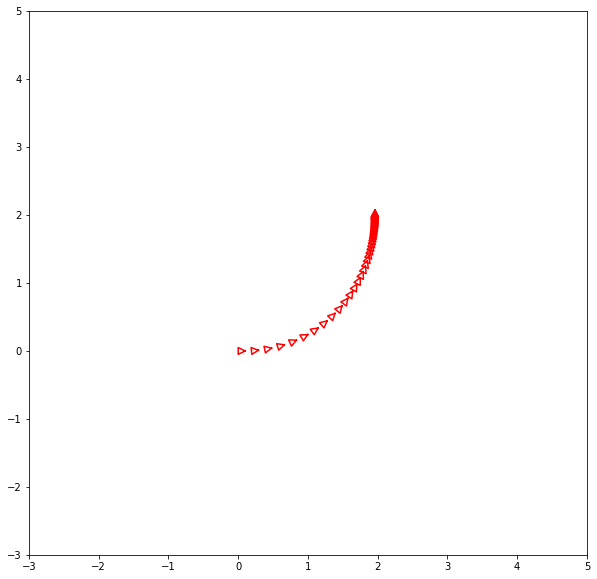

In [5]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()

In [6]:
def lqr_rob(A, B, T=100):
    Q = np.eye(3)
    R = np.eye(2)
    P = np.zeros((3,3))
    for t in range(T):
        K = -linalg.inv(R+B.T@P@B)@B.T@P@A
        P = (Q + K.T@R@K + (A+B@K).T@P@(A+B@K))
        
    return K

In [7]:
dt = 0.1
     
x = np.array([0.,0.,0.]) 

xf = np.array([2.000,2.000,np.pi/2])  

track = []
unicycle = Unicycle(x=x)

for i in range(200):
    x = unicycle.x
    print(f'iteration = {i}')
    print(f'Current State = {x}')
    print(f'Desired State = {xf}')

    error = x - xf
    track.append(x)
    state_error_magnitude = np.linalg.norm(error)     
    print(f'State Error Magnitude = {state_error_magnitude}')

    B = unicycle.getB(x=x, dt=dt)
    A = unicycle.getA(np.zeros(2), x=x, dt=dt)
        
    K = lqr_rob(A, B) 
    u = K@error
    
    print(f'Control Input = {u}')

    x=unicycle.f(u, x=x, dt=dt)  
    
    if state_error_magnitude < 0.05:
        print(f"\nGoal Has Been Reached Successfully in {i} iterations!")
        break

    print()

iteration = 0
Current State = [0. 0. 0.]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.2353363194994644
Control Input = [1.90249843 1.49421877]

iteration = 1
Current State = [0.19024984 0.         0.10471976]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 3.0699472543816855
Control Input = [1.91095797 1.39460419]

iteration = 2
Current State = [0.3802988  0.01997495 0.20943951]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.8977963295272926
Control Input = [1.89867175 1.2949896 ]

iteration = 3
Current State = [0.56601692 0.05945056 0.31415927]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.7205103068757923
Control Input = [1.86774141 1.19537502]

iteration = 4
Current State = [0.74364968 0.11716694 0.41887902]
Desired State = [2.         2.         1.57079633]
State Error Magnitude = 2.539761787380444
Control Input = [1.82026324 1.09576043]

iteration = 5
Current Sta

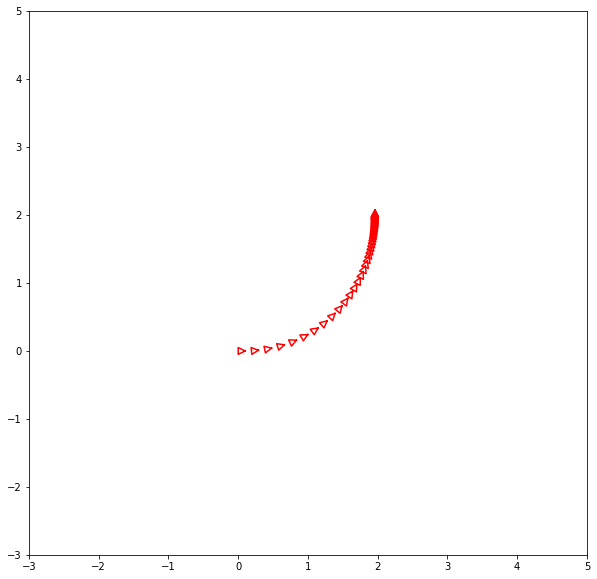

In [8]:
plt.subplots(figsize=(10,10))
plt.xlim(-3,5)
plt.ylim(-3,5)
for x in track:
    unicycle.plot(x)
plt.show()